## Predicting Used Car Prices Using Regression Analysis - by Gabriel Cheuk

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Problem
<ul>
    <li>Do all cars depreciate at the same rate?</li>
    <li>Can we use regression to predict a used car's value?</li>
    <li>Is it possible to get a reference price of a used car taking into account its peculiarities?</li>
</ul>    

## Metrics
Since the dataset is scraped from the UK, the currency of the price is in pounds, and the UK's mpg is not equivalent to the U.S.'s mpg. To make my analysis relevant and comparable in the U.S., I converted the price from pounds to the US currency dollar by multiplying a factor of 1.29. I also converted UK's mpg to the U.S.'s mpg by multiplying a factor of 0.83.

In [2]:
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
files = ['AUDI.csv','BMW.csv','FORD.csv','HYUNDAI.csv','MERCEDES.csv','SKODA.csv','TOYOTA.csv','VAUXHALL.csv','VOLKSWAGEN.csv']
dfs = ['AUDI','BMW','FORD','HYUNDAI','MERCEDES','SKODA','TOYOTA','VAUXHALL','VOLKSWAGEN']

# Read CSV files and merge
dataframe = []
for file in files:
    dataframe.append(pd.read_csv(file))
    
df = pd.concat(dataframe, axis='rows')

# Rename columns and add column age
df.rename(columns = {'fuelType':'fuel_type', 'engineSize':'engine_size'}, inplace=True)
df['age'] = 2021 - df['year']

# Shape and preview of dataset
df.shape
df.head()

(99187, 11)

,brand,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,age
0,Audi,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,5
2,Audi,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,5
3,Audi,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,4
4,Audi,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,2


### Data Cleaning

In [4]:
# shape of the dataframe
df.shape

# data type of each column
df.dtypes

(99187, 11)

brand            object
model            object
year              int64
price             int64
transmission     object
mileage           int64
fuel_type        object
tax               int64
mpg             float64
engine_size     float64
age               int64
dtype: object

In [5]:
# number of na and null values
df.isna().sum()
df.isnull().sum()

brand           0
model           0
year            0
price           0
transmission    0
mileage         0
fuel_type       0
tax             0
mpg             0
engine_size     0
age             0
dtype: int64

brand           0
model           0
year            0
price           0
transmission    0
mileage         0
fuel_type       0
tax             0
mpg             0
engine_size     0
age             0
dtype: int64

In [6]:
# number of unique values 
df.nunique()

# summary statistics
statistics = df.describe()
statistics

brand               9
model             195
year               27
price           13236
transmission        4
mileage         42214
fuel_type           5
tax                48
mpg               208
engine_size        40
age                27
dtype: int64

,year,price,mileage,tax,mpg,engine_size,age
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280,3.912277
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646,2.123934
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000,-39.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000,2.000000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000,4.000000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000,5.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000,51.000000


In [7]:
brand_no = df.brand.nunique()
brands = df.brand.unique()
print("This dataframe has {} unique brand values with the following:{}".format(brand_no, brands))

This dataframe has 9 unique brand values with the following:['Audi' 'BMW' 'Ford' 'Hyundai' 'Mercedes' 'Skoda' 'Toyota' 'Vauxhall'
 'Volkswagen']


In [8]:
print("As the seller has no control over tax, it was deemed as an unnecessary variable and was dropped")
df = df.drop('tax', axis=1)

As the seller has no control over tax, it was deemed as an unnecessary variable and was dropped


In [9]:
# convert all numerical variables to numeric values
df[['year','price','mileage']] = df[['year','price','mileage']].apply(pd.to_numeric)
df[['mpg','engine_size']] = df[['mpg','engine_size']].apply(pd.to_numeric)

# convert price in pounds to dollars 
df['price'] = df['price'] * 1.29

# convert UK's mpg to the U.S.'s mpg by multiplying by 0.83
df['mpg'] = df['mpg'] * 0.83

# convert price, mileage, age, and mpg to integers
df[['year','price','mileage','mpg']] = df[['year','price','mileage','mpg']].astype(int)

In [10]:
print("Cars from earlier than 1995 and later than 2020 were dropped.")
index_2060 = df[df['year']==2060].index
index_1995 = df[df['year']<1995].index
indexes = [index_2060, index_1995]
for i in indexes:
    df = df.drop(i)

Cars from earlier than 1995 and later than 2020 were dropped.


In [11]:
print("Cars with odometers reading more than 250k were dropped, and \
cars with odometers reading less than 100 miles were also dropped as they were considered as new cars.")
index_miles250k = df[df['mileage'] > 250000].index
index_miles100 = df[df['mileage'] < 100].index
indexes = [index_miles250k ,index_miles100]
for i in indexes:
    df = df.drop(i)

Cars with odometers reading more than 250k were dropped, and cars with odometers reading less than 100 miles were also dropped as they were considered as new cars.


In [12]:
# drop prices that are unreasonable
a = df.price[df['price'] > 100000].count()
b = df.price[df['price'] < 1000].count()
c = df.price.count()
print("Cars that were listed as more than $100,000 were dropped. \
There were only {0} out of {1} data points that has over 100k price value. It addresses only a small percentage of buyers. \
In addition, there were {2} cars that has a price lower than $1,000. \
These values were also dropped from the dataframe because these prices are noise for the data.".format(a, c, b))

index_price100k = df[df['price'] > 100000].index
index_price1k = df[df['price'] < 1000].index
indexes = [index_price100k, index_price1k]
for i in indexes:
    df = df.drop(i)

Cars that were listed as more than $100,000 were dropped. There were only 91 out of 82388 data points that has over 100k price value. It addresses only a small percentage of buyers. In addition, there were 10 cars that has a price lower than $1,000. These values were also dropped from the dataframe because these prices are noise for the data.


In [13]:
print('Drop datapoints with 0 engine size and mpg <10.')
enginesize0 = df[df.engine_size == 0].index
df = df.drop(enginesize0)
df = df.drop(df[df.mpg<10].index)

Drop datapoints with 0 engine size and mpg <10.


In [14]:
# Relabel semi-automatic transmission as manual as they are still reliant on a clutch. 
# Researched the cars labeled as 'Other' and categorized them as automatic transmissions. 
df.transmission.unique()
d = {'Other':'Automatic', 'Semi-Auto':'Manual'}
df.transmission = df.transmission.replace(d)

array(['Manual', 'Automatic', 'Semi-Auto', 'Other'], dtype=object)

In [15]:
# Relabel Petroleum as Gasoline
# Reassign 'Automatic' values as Gasoline
df.fuel_type.unique()
f = {'Petrol':'Gasoline','Other':'Gasoline'}
df.fuel_type = df.fuel_type.replace(f)
df.reset_index(drop=True)

array(['Petrol', 'Diesel', 'Hybrid', 'Other', 'Electric'], dtype=object)

,brand,model,year,price,transmission,mileage,fuel_type,mpg,engine_size,age
0,Audi,A1,2017,16125,Manual,15735,Gasoline,45,1.4,4
1,Audi,A6,2016,21285,Automatic,36203,Diesel,53,2.0,5
2,Audi,A1,2016,14190,Manual,29946,Gasoline,45,1.4,5
3,Audi,A4,2017,21672,Automatic,25952,Diesel,55,2.0,4
4,Audi,A3,2019,22317,Manual,1998,Gasoline,41,1.0,2
...,...,...,...,...,...,...,...,...,...,...
80170,Volkswagen,Eos,2012,7727,Manual,74000,Diesel,48,2.0,9
80171,Volkswagen,Fox,2008,2320,Manual,88102,Gasoline,38,1.2,13
80172,Volkswagen,Fox,2009,2051,Manual,70000,Gasoline,34,1.4,12
80173,Volkswagen,Fox,2006,1612,Manual,82704,Gasoline,38,1.2,15


In [16]:
# save and export clean dataset to csv
df.to_csv('clean used car dataset.csv')

### Exploratory Data Analysis Using Data Visualizations

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Boxplot for price and mileage')

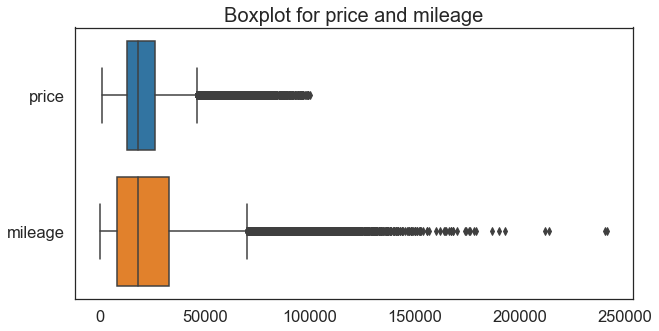

The average price of used cars is  $21,248.
The average mileage of used cars is  $23,832.


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Boxplot for fuel type')

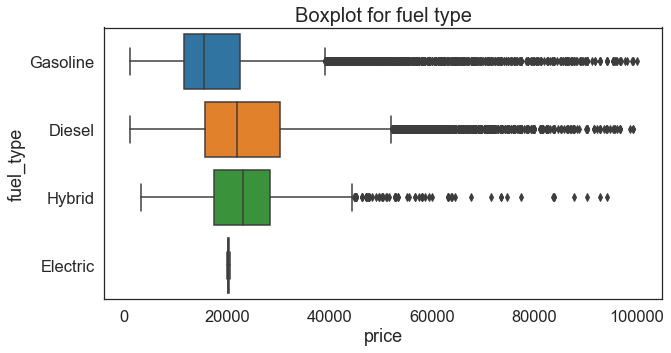

Cars running on Gasoline have an average price of $18,577.
Cars running on Diesel have an average price of $24,574.
Hybrid cars have an average price of $24,433.
Electric cars have an average price of $20,301.


In [17]:
# Set style, color, and figure size
sns.set(font_scale=1.5)
sns.set_style('white', rc={'patch.force_edgecolor':True,'patch.edgecolor': 'black'})
sns.set_palette(sns.color_palette('tab10'))
plt.rcParams['figure.figsize']= (15,5)

# variables
df_1 = df[['price','mileage']]
df_2 = df['fuel_type']

# box plots for price and mileage
plt.figure(figsize=(10,5))
bp = sns.boxplot(data=df_1, orient='h')
bp.set_title('Boxplot for price and mileage', fontsize=20)
plt.savefig('Boxplot for price and mileage.png', bbox_inches='tight', dpi=300)
plt.show()
print('The average price of used cars is  ${:,.0f}.'.format(df.price.mean()))
print('The average mileage of used cars is  ${:,.0f}.'.format(df.mileage.mean()))

# box plot for fuel type
plt.figure(figsize=(10,5))
bp2 = sns.boxplot(y=df_2, x=df.price, orient='h')
bp2.set_title('Boxplot for fuel type', fontsize=20)
plt.savefig('Boxplot for fuel type.png', bbox_inches='tight', dpi=300)
plt.show()
print('Cars running on Gasoline have an average price of ${:,.0f}.'.format(df.price[df.fuel_type=='Gasoline'].mean()))
print('Cars running on Diesel have an average price of ${:,.0f}.'.format(df.price[df.fuel_type=='Diesel'].mean()))
print('Hybrid cars have an average price of ${:,.0f}.'.format(df.price[df.fuel_type=='Hybrid'].mean()))
print('Electric cars have an average price of ${:,.0f}.'.format(df.price[df.fuel_type=='Electric'].mean()))

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Market Segmented by Brand Image')

34.57% of the market is a luxury car.
65.43% of the market is a nonluxury car.


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Average Price of Luxury vs. Non-Luxury Car Brands')

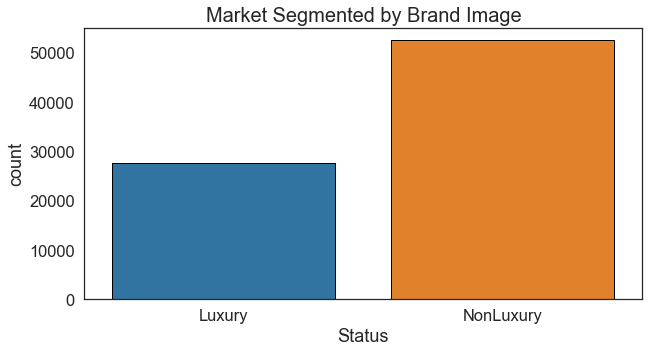

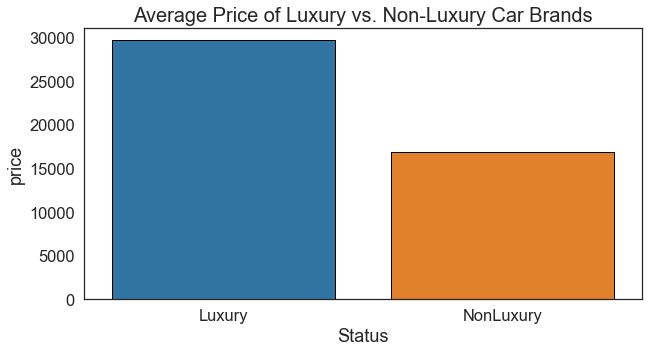

The average price for a luxury car is $29,620.
The average price for a nonluxury car is $16,825.


In [18]:
df_status = df
df_status['Status'] = ['Luxury' if (x == 'Audi')|(x == 'BMW')|(x == 'Mercedes') else 'NonLuxury' for x in  df.brand]
luxury_perc = df_status.Status[df_status.Status=='Luxury'].count()/df_status.Status.count()
nonluxury_perc = df_status.Status[df_status.Status=='NonLuxury'].count()/df_status.Status.count()

# plot market segmented by brand image
plt.figure(figsize=(10,5))
cp = sns.countplot(data=df_status, x='Status', edgecolor='black')
cp.set_title('Market Segmented by Brand Image', fontsize=20)
plt.savefig('Market Segmented by Brand Image.png', bbox_inches='tight', dpi=300)
print('{:.2%} of the market is a luxury car.'.format(luxury_perc))
print('{:.2%} of the market is a nonluxury car.'.format(nonluxury_perc))

# plot average price of luxury vs nonluxury cars
plt.figure(figsize=(10,5))
bp = sns.barplot(data=df_status, x='Status', y='price', edgecolor='black', ci=None)
bp.set_title('Average Price of Luxury vs. Non-Luxury Car Brands', fontsize=20)
plt.savefig('Average Price of Luxury vs Non-Luxury Car Brands.png', bbox_inches='tight', dpi=300)
plt.show()

# Price comparison between car status
print('The average price for a luxury car is ${:,.0f}.'.format(df_status.price[df_status.Status == 'Luxury'].mean()))
print('The average price for a nonluxury car is ${:,.0f}.'.format(df_status.price[df_status.Status == 'NonLuxury'].mean()))

brand
Mercedes      31061.920433
Audi          28753.476219
BMW           28671.233205
Volkswagen    21424.023945
Skoda         18082.613934
Hyundai       16085.282940
Toyota        15940.230724
Ford          15693.171002
Vauxhall      13301.294176
Name: price, dtype: float64

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Average Price per Car Brand')

The average price for a(n) Audi is $28,753.
The average price for a(n) BMW is $28,671.
The average price for a(n) Ford is $15,693.
The average price for a(n) Hyundai is $16,085.
The average price for a(n) Mercedes is $31,062.
The average price for a(n) Skoda is $18,083.
The average price for a(n) Toyota is $15,940.
The average price for a(n) Vauxhall is $13,301.
The average price for a(n) Volkswagen is $21,424.


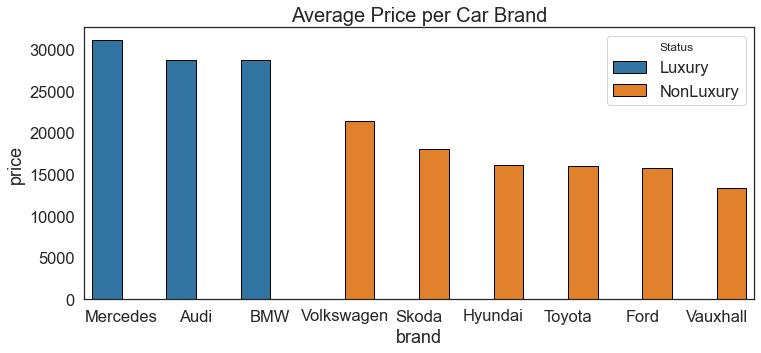

In [19]:
df_status.groupby('brand').mean().sort_values('price',ascending=False).price
result = ['Mercedes','Audi','BMW','Volkswagen','Skoda','Hyundai','Toyota','Ford','Vauxhall']

# Plot for brands
plt.figure(figsize=(12,5))
sns.barplot(data=df_status, x='brand', y='price', hue='Status', order=result, ci=None)
plt.title('Average Price per Car Brand', fontsize=20)
plt.savefig('Average Price per Car Brand.png', bbox_inches='tight', dpi=300)

# Print average price of brands
brands = ['Audi','BMW','Ford','Hyundai','Mercedes','Skoda','Toyota','Vauxhall','Volkswagen']
for i in brands:
    print('The average price for a(n) {} is ${:,.0f}.'.format(i, df.price[df.brand==i].mean()))

144093980.07888922

Text(0.5, 1.0, 'Price Distribution')

Text(0.5, 0, 'Price')

Text(0.68, 0.94, 'Price Variance: 144093980.08')

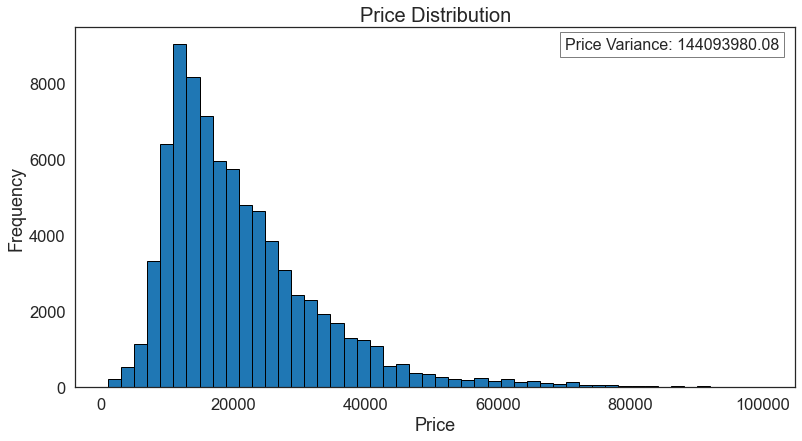

0.279416729864998

Text(0.5, 1.0, 'Normalized Price Distribution')

Text(0.5, 0, 'Price')

Text(0.745, 0.94, 'Price Log Variance: 0.28')

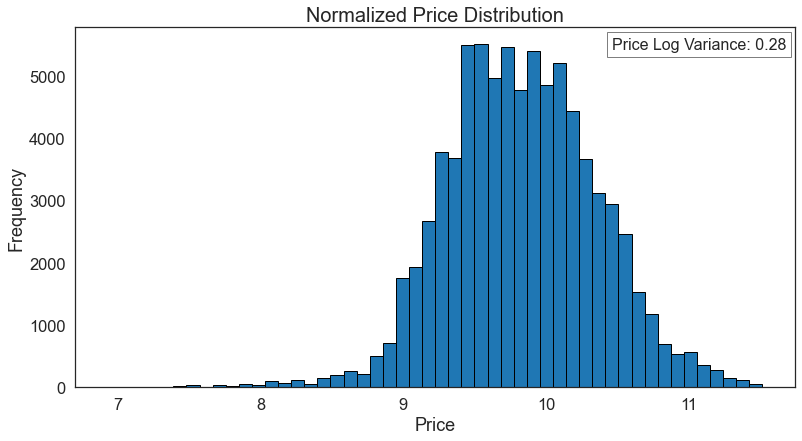

In [20]:
# Check price variance
df.price.var()
price_var = 'Price Variance: ' + str("{0:.2f}".format(df.price.var()))

# plot price variance
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0, 0, 1, 1])
df.price.plot.hist(bins=50, edgecolor='black')
plt.title('Price Distribution', fontsize=20)
plt.xlabel('Price', fontsize=18)
plt.text(0.68, 0.94, price_var, transform=ax.transAxes, fontsize=16, bbox={'facecolor':'white', 'alpha':.5, 'pad':5})
plt.savefig('Price Distribution.png', bbox_inches='tight', dpi=300)
plt.show()

# log transform price variance to normalize data
df['price_log'] = np.log(df.price)
df.price_log.var()
price_log_var = 'Price Log Variance: ' + str("{0:.2f}".format(df.price_log.var()))

# plot price_log variance
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0, 0, 1, 1])
df.price_log.plot.hist(bins=50, edgecolor='black')
plt.title('Normalized Price Distribution', fontsize=20)
plt.xlabel('Price', fontsize=18)
plt.text(0.745, 0.94, price_log_var, transform=ax.transAxes, fontsize=16, bbox={'facecolor':'white', 'alpha':.5, 'pad':5})
plt.savefig('Normalized Price Distribution.png', bbox_inches='tight', dpi=300)
plt.show()

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Scatter plot for year by price')

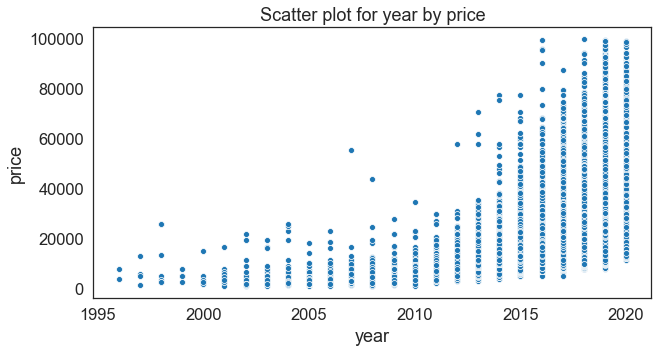

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Scatter plot for mileage by price')

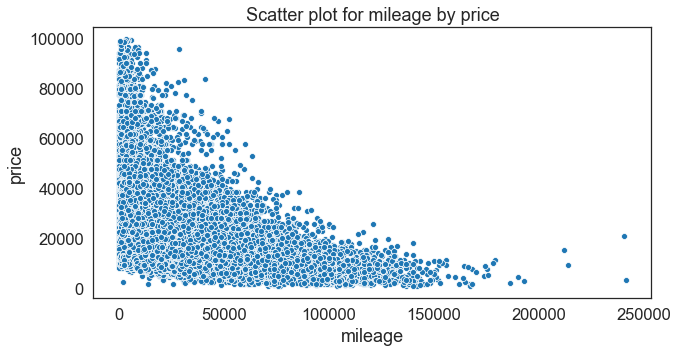

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Scatter plot for mpg by price')

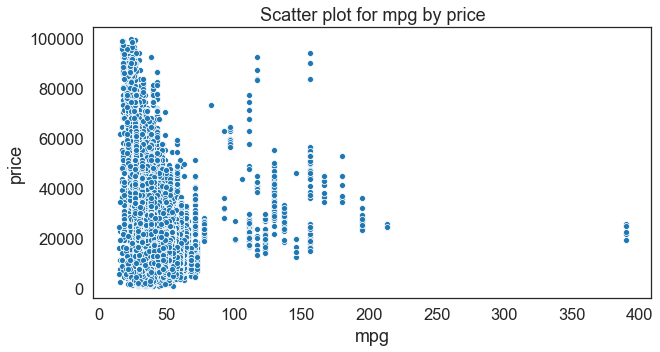

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Scatter plot for engine_size by price')

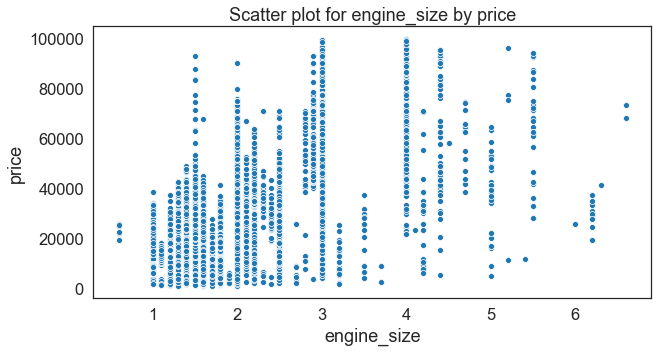

In [21]:
num_val = ['year','mileage','mpg','engine_size']
#sns.set_palette('muted')
for i in num_val:
    plt.figure(figsize=(10,5))
    g = sns.scatterplot(data=df, x=df[i], y=df['price'], alpha=1)
    plt.title('Scatter plot for {} by price'.format(i))
    plt.savefig('Scatter plot for {} by price.png'.format(i),bbox_inches='tight', dpi=300)
    plt.show()

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution Plot of price')

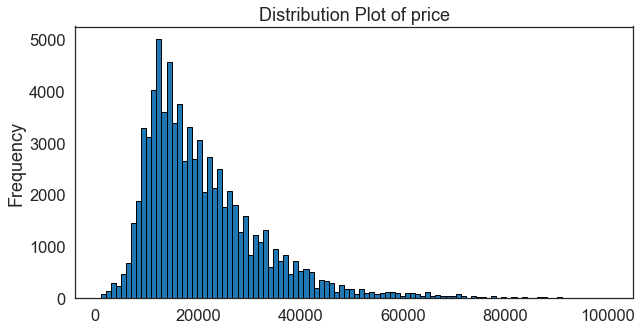

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution Plot of year')

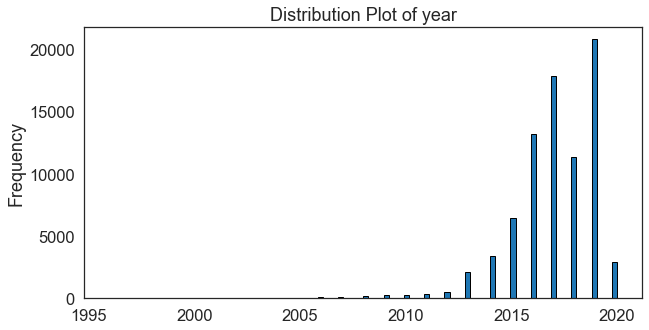

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution Plot of mileage')

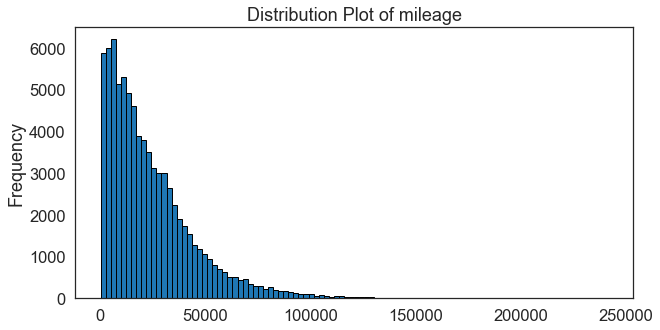

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution Plot of mpg')

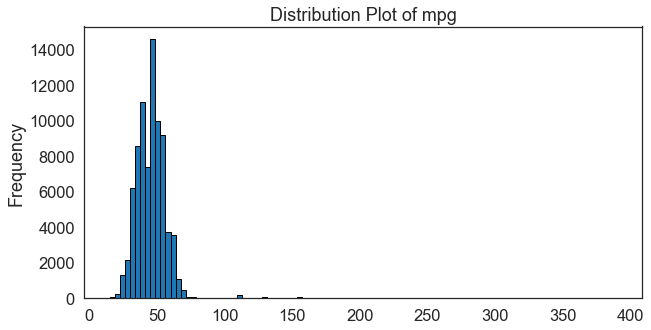

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution Plot of engine_size')

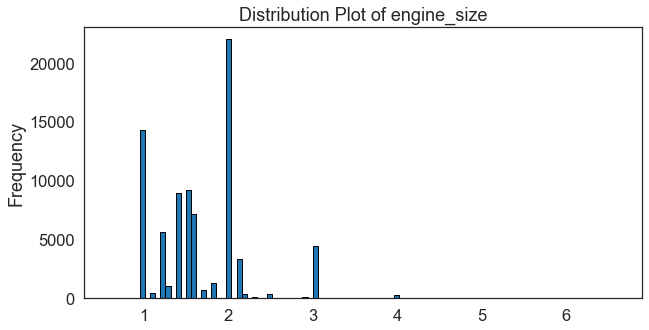

In [22]:
var = ['price','year','mileage','mpg','engine_size']
hist_ = {}
for i in var:
    plt.figure(figsize=(10,5))
    hist_[i]= df[i].plot.hist(bins=100, edgecolor='black')
    hist_[i].set_title('Distribution Plot of {}'.format(i))
    plt.savefig('Distribution Plot of {}.png'.format(i),bbox_inches='tight', dpi=300)
    plt.show()

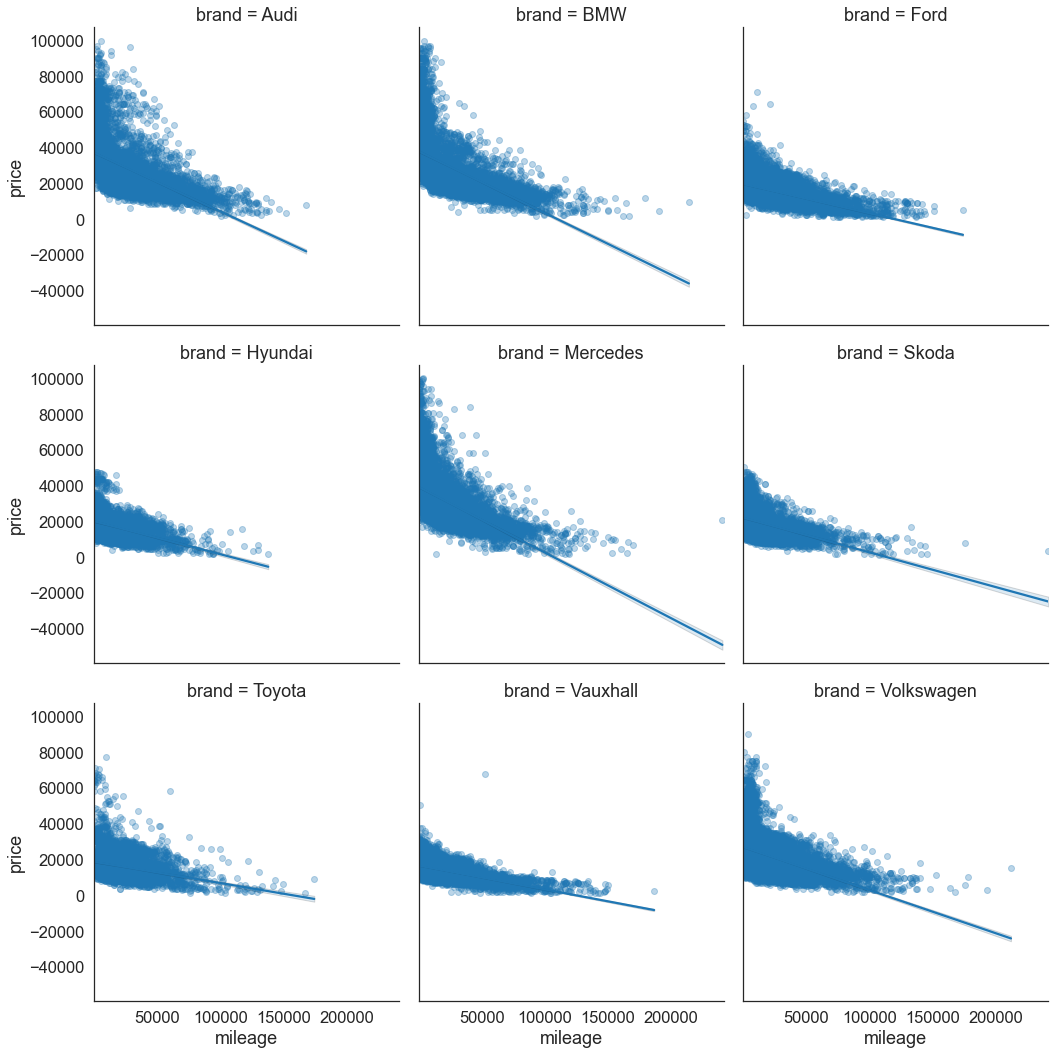

In [23]:
plt.rcParams['figure.figsize'] = (15,5)
sns.set_palette('tab10')
g = sns.lmplot(data=df, x='mileage', y='price', col='brand', col_wrap=3, height=5, aspect=1, scatter_kws={'alpha':0.3})
plt.savefig('Regression Plots.png',bbox_inches='tight', dpi=300)
plt.show()

#### Use one hot encoding to transform **transmission** and **fuel_type** variables into numerical values.

In [24]:
# One hot encoding for 'transmission'
df_dummy = pd.get_dummies(df.transmission)
df_dummy2 = pd.get_dummies(df.fuel_type)
df_combined = [df, df_dummy, df_dummy2]

# Horizontally concatenate the encoded series with the dataframe 
data = pd.concat(df_combined, axis=1)

# Drop column 'transmission'
data = data.drop(['transmission', 'fuel_type'], axis=1)
data

,brand,model,year,price,mileage,mpg,engine_size,age,Status,price_log,Automatic,Manual,Diesel,Electric,Gasoline,Hybrid
0,Audi,A1,2017,16125,15735,45,1.4,4,Luxury,9.688126,0,1,0,0,1,0
1,Audi,A6,2016,21285,36203,53,2.0,5,Luxury,9.965758,1,0,1,0,0,0
2,Audi,A1,2016,14190,29946,45,1.4,5,Luxury,9.560293,0,1,0,0,1,0
3,Audi,A4,2017,21672,25952,55,2.0,4,Luxury,9.983776,1,0,1,0,0,0
4,Audi,A3,2019,22317,1998,41,1.0,2,Luxury,10.013104,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15152,Volkswagen,Eos,2012,7727,74000,48,2.0,9,NonLuxury,8.952476,0,1,1,0,0,0
15153,Volkswagen,Fox,2008,2320,88102,38,1.2,13,NonLuxury,7.749322,0,1,0,0,1,0
15154,Volkswagen,Fox,2009,2051,70000,34,1.4,12,NonLuxury,7.626083,0,1,0,0,1,0
15155,Volkswagen,Fox,2006,1612,82704,38,1.2,15,NonLuxury,7.385231,0,1,0,0,1,0


#### Encoding categorical variable, Brand, by one hot encoding.

In [25]:
# Get one hot encoding for column 'Brand'
data_dummy = pd.get_dummies(data['brand'])
data_combined = [data, data_dummy]

# Concatenate the encoded df horizontally
data = pd.concat(data_combined, axis=1)

# Drop the Column Brand and Model
data = data.drop('brand', axis=1)
data

,model,year,price,mileage,mpg,engine_size,age,Status,price_log,Automatic,...,Hybrid,Audi,BMW,Ford,Hyundai,Mercedes,Skoda,Toyota,Vauxhall,Volkswagen
0,A1,2017,16125,15735,45,1.4,4,Luxury,9.688126,0,...,0,1,0,0,0,0,0,0,0,0
1,A6,2016,21285,36203,53,2.0,5,Luxury,9.965758,1,...,0,1,0,0,0,0,0,0,0,0
2,A1,2016,14190,29946,45,1.4,5,Luxury,9.560293,0,...,0,1,0,0,0,0,0,0,0,0
3,A4,2017,21672,25952,55,2.0,4,Luxury,9.983776,1,...,0,1,0,0,0,0,0,0,0,0
4,A3,2019,22317,1998,41,1.0,2,Luxury,10.013104,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,7727,74000,48,2.0,9,NonLuxury,8.952476,0,...,0,0,0,0,0,0,0,0,0,1
15153,Fox,2008,2320,88102,38,1.2,13,NonLuxury,7.749322,0,...,0,0,0,0,0,0,0,0,0,1
15154,Fox,2009,2051,70000,34,1.4,12,NonLuxury,7.626083,0,...,0,0,0,0,0,0,0,0,0,1
15155,Fox,2006,1612,82704,38,1.2,15,NonLuxury,7.385231,0,...,0,0,0,0,0,0,0,0,0,1


#### Binning 'Ages' by intervals of 4.

With the common understanding that cars depreciate over time, I am interested to see the incremental impacts of time on a car's resell value. How much does 1 year impact a car's value when we're looking at cars within 1, 2, or 3 years apart. Hence, we will bin the age variable by intervals of 4 and run a regression analysis to determine if binning can improve prediction accuracy.

In [26]:
mybins = np.arange(0,29,4)
mylabels = np.arange(1,8,1)
data['age_bins'] = pd.cut(x=data.age, bins=mybins, labels=mylabels)
data['age_bins'] = pd.factorize(data['age_bins'])[0] +1
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80175 entries, 0 to 15156
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   model        80175 non-null  object 
 1   year         80175 non-null  int64  
 2   price        80175 non-null  int64  
 3   mileage      80175 non-null  int64  
 4   mpg          80175 non-null  int64  
 5   engine_size  80175 non-null  float64
 6   age          80175 non-null  int64  
 7   Status       80175 non-null  object 
 8   price_log    80175 non-null  float64
 9   Automatic    80175 non-null  uint8  
 10  Manual       80175 non-null  uint8  
 11  Diesel       80175 non-null  uint8  
 12  Electric     80175 non-null  uint8  
 13  Gasoline     80175 non-null  uint8  
 14  Hybrid       80175 non-null  uint8  
 15  Audi         80175 non-null  uint8  
 16  BMW          80175 non-null  uint8  
 17  Ford         80175 non-null  uint8  
 18  Hyundai      80175 non-null  uint8  
 19  Merc

,model,year,price,mileage,mpg,engine_size,age,Status,price_log,Automatic,...,Audi,BMW,Ford,Hyundai,Mercedes,Skoda,Toyota,Vauxhall,Volkswagen,age_bins
0,A1,2017,16125,15735,45,1.4,4,Luxury,9.688126,0,...,1,0,0,0,0,0,0,0,0,1
1,A6,2016,21285,36203,53,2.0,5,Luxury,9.965758,1,...,1,0,0,0,0,0,0,0,0,2
2,A1,2016,14190,29946,45,1.4,5,Luxury,9.560293,0,...,1,0,0,0,0,0,0,0,0,2
3,A4,2017,21672,25952,55,2.0,4,Luxury,9.983776,1,...,1,0,0,0,0,0,0,0,0,1
4,A3,2019,22317,1998,41,1.0,2,Luxury,10.013104,0,...,1,0,0,0,0,0,0,0,0,1


### Segmentation Analysis
<p style='font-size: 10.5pt'>
    Segment the dataframe into luxury vs non-luxury brands
</p>

In [27]:
data_seg = data.copy()
data_seg['luxury'] = np.select([data_seg.Audi == 1, data_seg.BMW == 1, data_seg.Mercedes == 1], [1,1,1])
data_seg['nonluxury'] = np.select([data_seg.luxury == 0], [1])
data_seg = data_seg.drop(['Audi','BMW','Ford','Hyundai','Mercedes','Skoda','Toyota','Vauxhall','Volkswagen'],axis=1)
data_seg

,model,year,price,mileage,mpg,engine_size,age,Status,price_log,Automatic,Manual,Diesel,Electric,Gasoline,Hybrid,age_bins,luxury,nonluxury
0,A1,2017,16125,15735,45,1.4,4,Luxury,9.688126,0,1,0,0,1,0,1,1,0
1,A6,2016,21285,36203,53,2.0,5,Luxury,9.965758,1,0,1,0,0,0,2,1,0
2,A1,2016,14190,29946,45,1.4,5,Luxury,9.560293,0,1,0,0,1,0,2,1,0
3,A4,2017,21672,25952,55,2.0,4,Luxury,9.983776,1,0,1,0,0,0,1,1,0
4,A3,2019,22317,1998,41,1.0,2,Luxury,10.013104,0,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,7727,74000,48,2.0,9,NonLuxury,8.952476,0,1,1,0,0,0,4,0,1
15153,Fox,2008,2320,88102,38,1.2,13,NonLuxury,7.749322,0,1,0,0,1,0,5,0,1
15154,Fox,2009,2051,70000,34,1.4,12,NonLuxury,7.626083,0,1,0,0,1,0,4,0,1
15155,Fox,2006,1612,82704,38,1.2,15,NonLuxury,7.385231,0,1,0,0,1,0,5,0,1


### Inferential Statistical Analysis
<p style="font-size:12pt">
    Using Seaborn's heatmap function to show the correlations (including R Squared) for all variables.
</p>

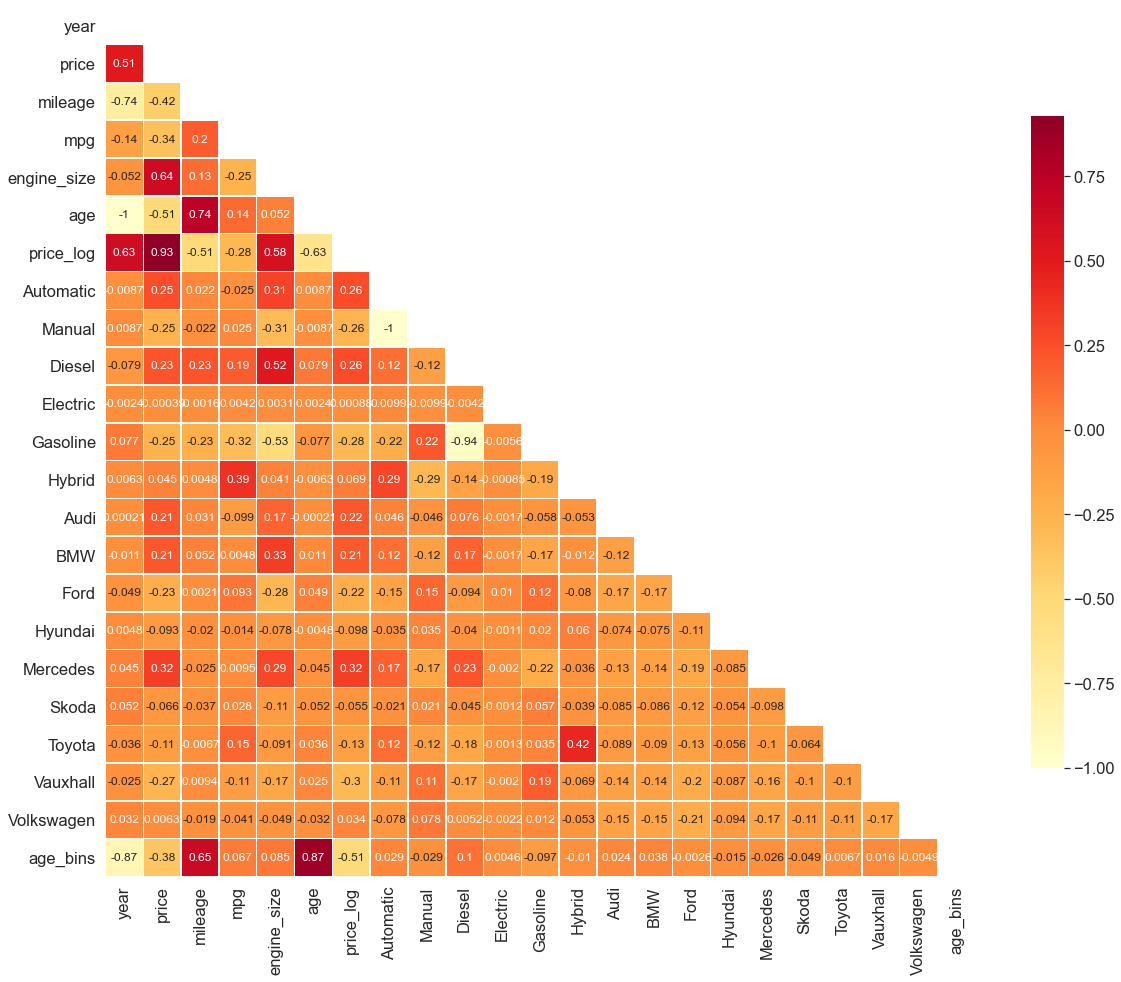

<Figure size 720x432 with 0 Axes>

Text(0, 0.5, 'Correlation Strength')

Text(0.5, 1.0, 'Variables Correlated with Ln of Price')

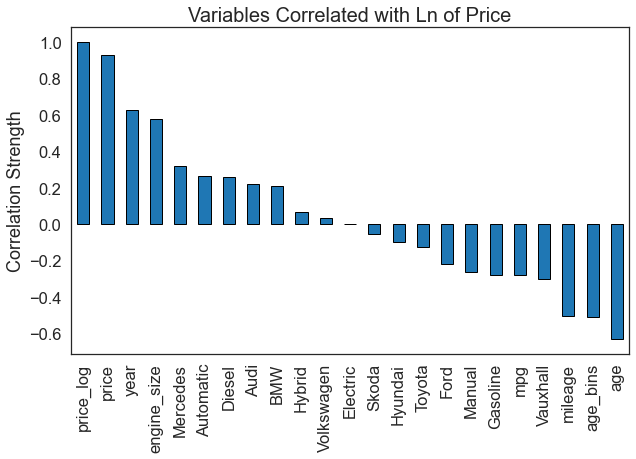

In [28]:
plt.rcParams['figure.figsize'] = (20,16)
corr = data.corr(method='pearson')

# Mask the upper triangular matrix and make a heatmap showing only the lower triangular matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation heat map
sns.heatmap(corr, cmap='YlOrRd', mask=mask, annot=True, annot_kws={"size":12}, center=0, linewidths='.5', square=True, cbar_kws={"shrink":.75})
plt.savefig('Correlation Matrix.png',bbox_inches='tight', dpi=300)
plt.show()

# Plot bargraph of correlation variables related to price_log
plt.figure(figsize=(10,6))
corr = corr.sort_values('price_log', ascending=False)
corr['price_log'].plot(kind='bar', edgecolor='black')
plt.ylabel('Correlation Strength', fontsize=18)
plt.title('Variables Correlated with Ln of Price', fontsize=20)
plt.show()

#### <span style='color:blue'> In the heatmap above, we observe that two independent variables, **year** and **mileage**, are highly correlated. If both variables are used in the regression analysis, it will cause collinearity. Thus, we will run our regression with the two variables separately to avoid collinearity and select the variable with a higher statistical signficance or the model with a better fit. 
</span>

#### Regression Analysis: All Variables

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 3.266e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:46:29   Log-Likelihood:                 15997.
No. Observations:               80175   AIC:                        -3.196e+04
Df Residuals:                   80159   BIC:                        -3.181e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -161.6546      0.371   -436.029      

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Car Make Year')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Predicted Price vs Original Price')

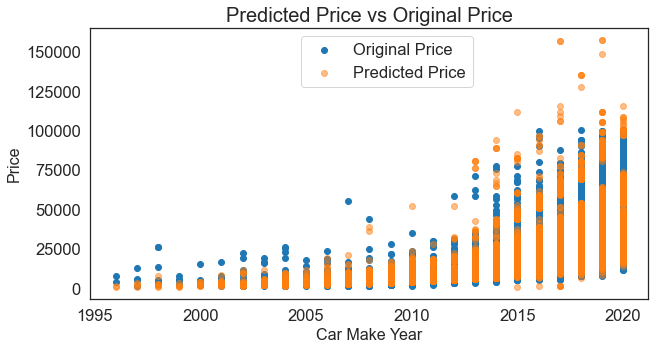

In [29]:
predictor_year = ['year','mpg','engine_size','Automatic','Manual','Gasoline', 'Diesel', 'Hybrid', 'Electric','Audi','BMW','Ford','Hyundai','Mercedes','Skoda','Toyota','Vauxhall','Volkswagen']
dependentVar = data['price_log']
# regression analysis using year
df_data = data[predictor_year]
df_data = sm.add_constant(df_data)
x1_year = df_data
y = dependentVar
olsres_year = sm.OLS(y,x1_year).fit()
print(olsres_year.summary())
print(olsres_year.pvalues)
print(olsres_year.params)

# Validate Predictions
plt.figure(figsize=(10,5))
plt.scatter(x=data['year'], y=data['price'], label='Original Price')
plt.scatter(x=data['year'],y=np.exp(olsres_year.predict(x1_year)), alpha=.5, label='Predicted Price')
plt.legend(bbox_to_anchor=(0.7,1), loc="best")
plt.xlabel('Car Make Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title('Predicted Price vs Original Price', fontsize=20)
plt.savefig('Predicted Price vs Original Price.png', bbox_inches='tight', dpi=300)
plt.show()

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Original - Predicted Price ')

Text(0.5, 1.0, 'Price Difference Plot')

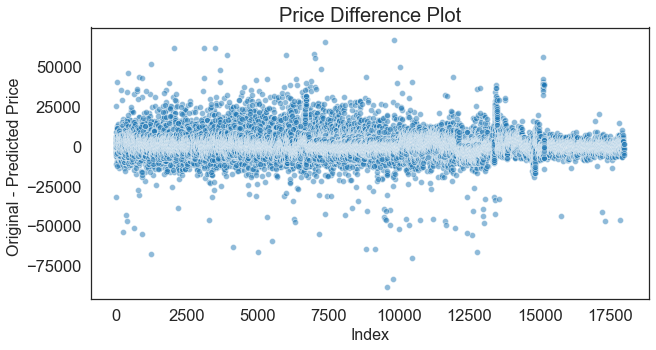

In [30]:
residuals = data.copy()
residuals['predicted'] = round(np.exp(olsres_year.predict(x1_year))).astype(int)
residuals['Residuals'] = residuals.price - residuals.predicted

# Validate Predictions
plt.figure(figsize=(10,5))
sns.scatterplot(x=residuals.index, y=residuals.Residuals, alpha=.5, x_jitter=0.2, y_jitter=0.2)
# plt.legend(bbox_to_anchor=(0.7,1), loc="best")
plt.xlabel('Index', fontsize=16)
plt.ylabel('Original - Predicted Price ', fontsize=16)
plt.title('Price Difference Plot', fontsize=20)
plt.savefig('Price Difference Plot.png', bbox_inches='tight', dpi=300)
plt.show()

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                 1.898e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:46:39   Log-Likelihood:                -1903.7
No. Observations:               80175   AIC:                             3839.
Df Residuals:                   80159   BIC:                             3988.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.3804      0.024    223.727      

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Car Make Year')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Predicted Price vs Original Price w/ Miles')

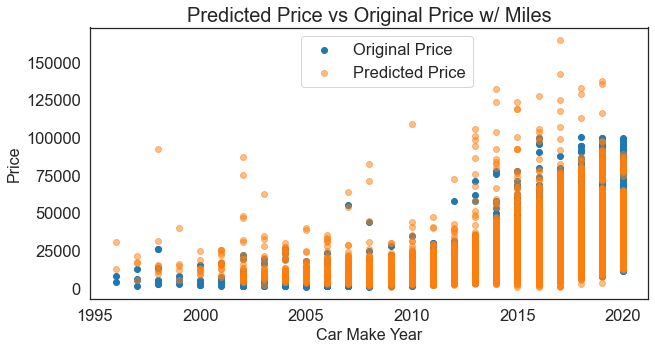

In [31]:
predictor_miles = ['mileage','mpg','engine_size','Automatic','Manual','Gasoline', 'Diesel', 'Hybrid', 'Electric','Audi','BMW','Ford','Hyundai','Mercedes','Skoda','Toyota','Vauxhall','Volkswagen']
dependentVar = data['price_log']

# regression analysis using mileage
df_data = data[predictor_miles]
df_data = sm.add_constant(df_data)
x1_miles = df_data
y = dependentVar
olsres_miles = sm.OLS(y,x1_miles).fit()
print(olsres_miles.summary())
print(olsres_miles.pvalues)
print(olsres_miles.params)

# Validate Predictions
plt.figure(figsize=(10,5))
plt.scatter(x=data['year'], y=data['price'], label='Original Price')
plt.scatter(x=data['year'],y=np.exp(olsres_miles.predict(x1_miles)), alpha=.5, label='Predicted Price')
plt.legend(bbox_to_anchor=(0.7,1), loc="best")
plt.xlabel('Car Make Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title('Predicted Price vs Original Price w/ Miles', fontsize=20)
plt.savefig('Predicted Price vs Original Price with Miles.png', bbox_inches='tight', dpi=300)

#### <span style='color:blue'> P-values for both year and mileage are extremely small. We look at the model with the better fit. The model with age as a predictor variable has a R^2 value of 0.859. The model with mileage as a predictor variable has a R^2 value of 0.78. Therefore, we can conclude that age is more significant and a better predictor than mileage. </span>

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

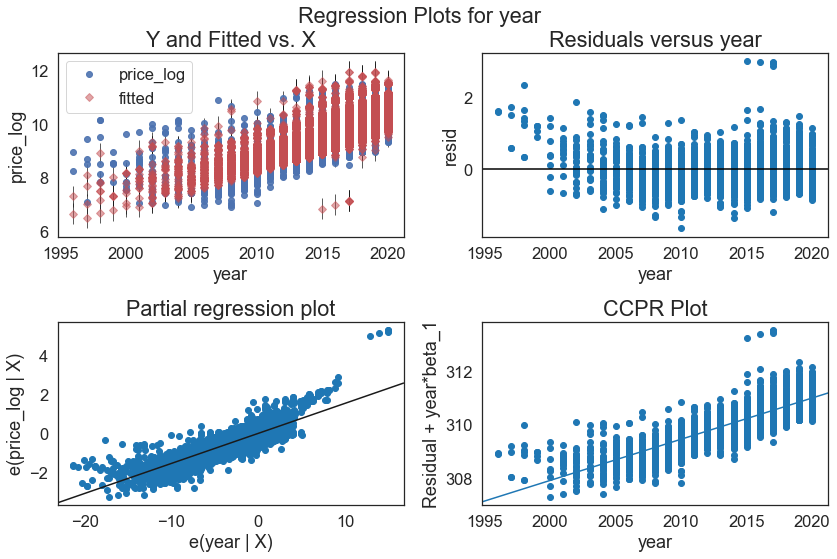

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

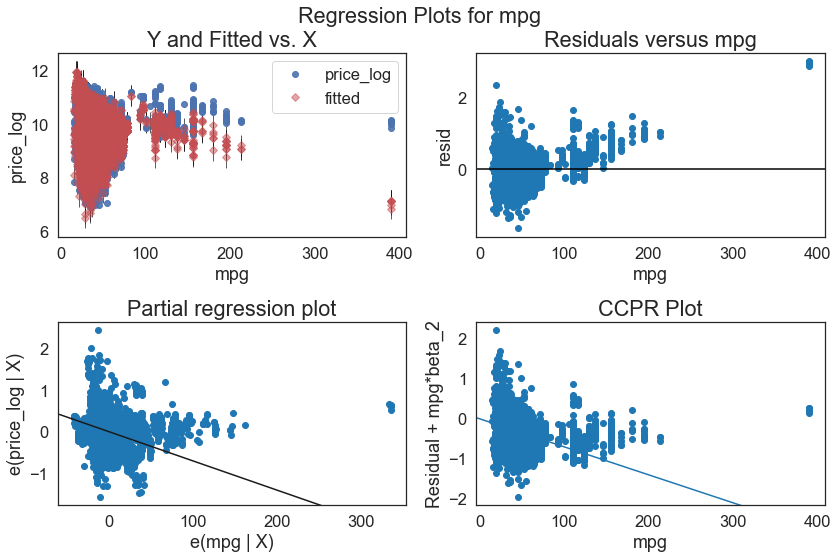

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

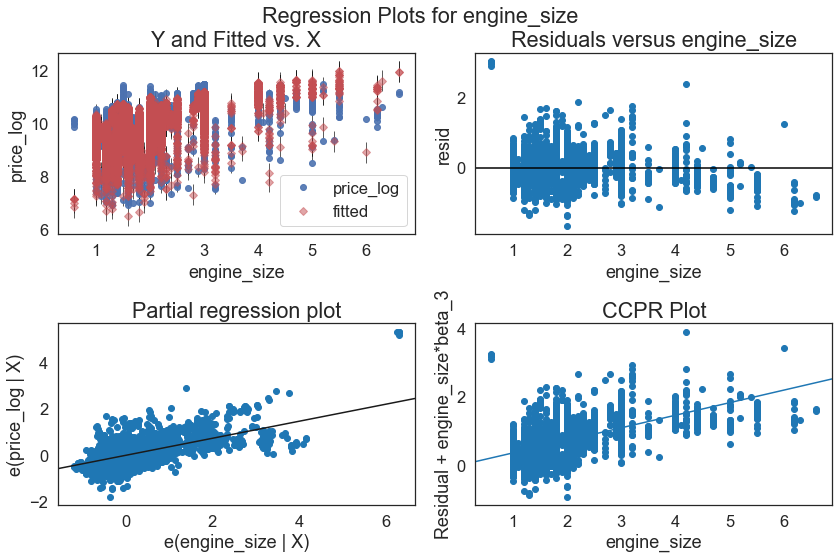

In [32]:
# Using residual plots to validate regression models
predictor = ['year','mpg','engine_size']
for i in predictor:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(olsres_year, i, fig=fig)
    plt.tight_layout
    plt.savefig('Residual Plots of {} against Price.png'.format(i),bbox_inches='tight', dpi=300)
    plt.show()

#### <span style='color:blue'> Observing the residual plots of age, mpg, and engine size plotted against price, we see that age is randomly distributed. Mpg and engine sizes are more clustered towards the left end of the axis, because they are inherently more distributed on the left end of the axis. Removing cars with mpg and engine sizes on the right end of the axis to normalize the variables removes pertinent data and creates bias. Overall, log transforming price has helped normalize the age variable and create a better fit for the model.  

#### Regression Analysis: Using Age Bins

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.845e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:47:37   Log-Likelihood:                -2783.9
No. Observations:               80175   AIC:                             5600.
Df Residuals:                   80159   BIC:                             5748.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.7139      0.024    234.971      

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Car Make Year')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Predicted Price vs Original Price w/ Age Bins')

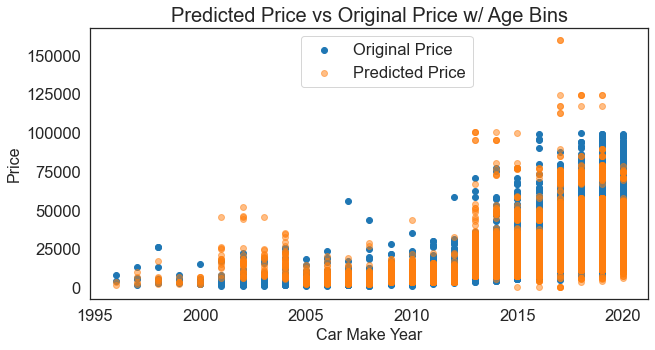

In [33]:
predictor_bins = ['age_bins','mpg','engine_size','Automatic','Manual','Gasoline', 'Diesel', 'Hybrid', 'Electric','Audi','BMW','Ford','Hyundai','Mercedes','Skoda','Toyota','Vauxhall','Volkswagen']
dependentVar = data['price_log']

# regression price on all variables
df_data2 = data[predictor_bins]
df_data2 = sm.add_constant(df_data2)
x2 = df_data2
y = dependentVar
olsres_bin = sm.OLS(y,x2).fit()
print(olsres_bin.summary())

# Validate Predictions
plt.figure(figsize=(10,5))
plt.scatter(x=data['year'], y=data['price'], label='Original Price')
plt.scatter(x=data['year'],y=np.exp(olsres_bin.predict(x2)), alpha=.5, label='Predicted Price')
plt.legend(bbox_to_anchor=(0.7,1), loc="best")
plt.xlabel('Car Make Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title('Predicted Price vs Original Price w/ Age Bins', fontsize=20)
plt.savefig('Predicted Price vs Original Price with Age Bins.png', bbox_inches='tight', dpi=300)

#### <span style="color:blue"> The R^2 value for the model using binned ages is 0.775, which is lower than the original model's R^2 value of 0.859. Based on these results, we conclude that binning the age variable is unbeneficial in predicting the price. </span>

#### Regression Analysis: Using segmented data of luxury vs non-luxury brands

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 4.711e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:47:43   Log-Likelihood:                 7127.0
No. Observations:               80175   AIC:                        -1.424e+04
Df Residuals:                   80166   BIC:                        -1.415e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -136.5455      0.340   -401.389      

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Car Make Year')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Predicted Price vs Original Price (Non/Luxury)')

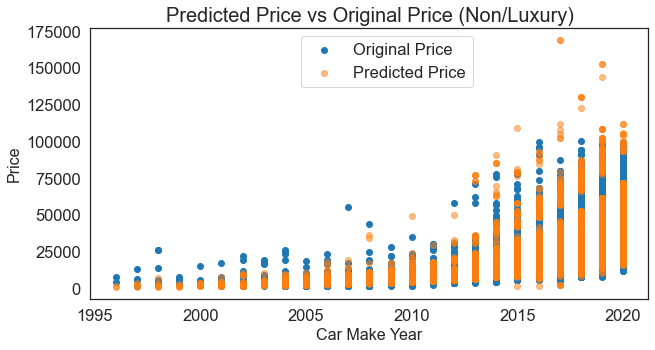

In [34]:
predictor2 = ['year','mpg','engine_size','Automatic','Manual','Gasoline', 'Diesel', 'Hybrid', 'Electric','luxury','nonluxury']
dependentVar2 = data_seg['price_log']

# regression analysis 
df_data_seg = data_seg[predictor2]
df_data_seg = sm.add_constant(df_data_seg)
x3 = df_data_seg
y = dependentVar2
olsres_seg = sm.OLS(y,x3).fit()
print(olsres_seg.summary())
print(olsres_seg.params)

# Validate Predictions
plt.figure(figsize=(10,5))
plt.scatter(x=data_seg['year'], y=data_seg['price'], label='Original Price')
plt.scatter(x=data_seg['year'],y=np.exp(olsres_seg.predict(x3)), alpha=.5, label='Predicted Price')
plt.legend(bbox_to_anchor=(0.7,1), loc="best")
plt.xlabel('Car Make Year', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title('Predicted Price vs Original Price (Non/Luxury)', fontsize=20)
plt.savefig('Predicted Price vs Original Price (Luxury).png', bbox_inches='tight', dpi=300)

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Original - Predicted Price ')

Text(0.5, 1.0, 'Price Difference Plot Using Car Status')

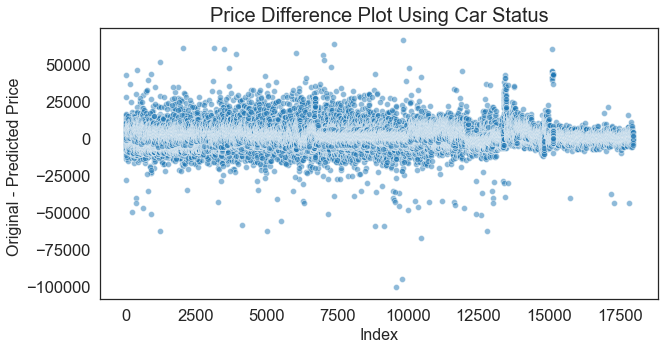

In [35]:
residuals2 = data_seg.copy()
residuals2['predicted'] = round(np.exp(olsres_seg.predict(x3))).astype(int)
residuals2['Residuals'] = residuals2.price - residuals2.predicted

# Validate Predictions
plt.figure(figsize=(10,5))
sns.scatterplot(x=residuals2.index, y=residuals2.Residuals, alpha=.5, x_jitter=0.2, y_jitter=0.2)
plt.xlabel('Index', fontsize=16)
plt.ylabel('Original - Predicted Price ', fontsize=16)
plt.title('Price Difference Plot Using Car Status', fontsize=20)
plt.savefig('Price Difference Plot Using Car Status.png', bbox_inches='tight', dpi=300)
plt.show()

#### <span style='color:blue'> Segmenting the dataset by a car's luxury or non-luxury brand provides a 82.5% fit for the model. Although this segmentation is not as accurate compared to our original model of 85.9% fit, it is still useful for consumers shopping for used cars without a specific brand in mind.

## Application

In [36]:
## Prediction using regression model 
# Leave variable as 1
const = 1
# Input numerical values for the car you want
year = 2013
mpg = 29
engine_size = 3.5
# Input 1 for the type of transmisison you want for your car and 0 for the other variable(s)
Automatic = 1
Manual = 0
# Input 1 for the type of fuel type you want for your car and 0 for the other variable(s)
Gasoline = 1
Diesel = 0
Hybrid = 0
Electric = 0 
# Input 1 for the type of car brand you want for your car and 0 for the other variable(s)
Audi = 0
BMW = 0
Ford = 0
Hyundai = 0
Mercedes = 1
Skoda = 0
Toyota = 0
Vauxhall = 0 
Volkswagen = 0 

Car = [const, year, mpg, engine_size, Automatic, Manual, Gasoline, Diesel, Hybrid, Electric, Audi, BMW, Ford, Hyundai, Mercedes, Skoda, Toyota, Vauxhall, Volkswagen]
car_price = float(np.exp(olsres_year.predict(Car)))
print('Your predicted car price is ${:,.2f}'.format(car_price))

# listed price from external source
# removing CA's 7.25% sales tax on cars
price = (1-0.0725) * 20998
# Est. Tax, Titles, & Fees (CA)
fees = 3450
listed_price = price + fees
print('From this website, https://www.carmax.com/car/18625423, the listed car price is ${:,.2f}.'.format(listed_price))

Your predicted car price is $28,035.72
From this website, https://www.carmax.com/car/18625423, the listed car price is $22,925.65.


In [37]:
# Prediction using regression model 
# Leave variable as 1
const = 1
# Input numerical values for the car you want
year = 2016
mpg = 27
engine_size = 4.0
# Input 1 for the type of transmisison you want for your car and 0 for the other variable(s)
Automatic = 1
Manual = 0
# Input 1 for the type of fuel type you want for your car and 0 for the other variable(s)
Gasoline = 1
Diesel = 0
Hybrid = 0
Electric = 0 
# Input 1 for the type of car brand you want for your car and 0 for the other variable(s)
Audi = 1
BMW = 0
Ford = 0
Hyundai = 0
Mercedes = 0
Skoda = 0
Toyota = 0
Vauxhall = 0 
Volkswagen = 0 

Car = [const, year, mpg, engine_size, Automatic, Manual, Gasoline, Diesel, Hybrid, Electric, Audi, BMW, Ford, Hyundai, Mercedes, Skoda, Toyota, Vauxhall, Volkswagen]
car_price = float(np.exp(olsres_year.predict(Car)))
print('Your predicted car price is ${:,.2f}'.format(car_price))

# listed price from external source
# removing CA's 7.25% sales tax on cars
price = (1-0.0725) * 42998
# Est. Tax, Titles, & Fees (CA)
fees = 6150
listed_price = price + fees
print('From this website, https://www.carmax.com/car/19345019, the listed car price is ${:,.2f}.'.format(listed_price))

Your predicted car price is $53,349.33
From this website, https://www.carmax.com/car/19345019, the listed car price is $46,030.64.


In [38]:
# Prediction using regression model with non/luxury 
# Leave variable as 1
const = 1
# Input numerical values for the car you want
year = 2010
mpg = 48
engine_size = 1.8
# Input 1 for the type of transmisison you want for your car and 0 for the other variable(s)
Automatic = 1
Manual = 0
# Input 1 for the type of fuel type you want for your car and 0 for the other variable(s)
Gasoline = 0
Diesel = 0
Hybrid = 1
Electric = 0 
# Input 1 for the type of luxury status you want for your car and 0 for the other variable(s)
Luxury = 0
Nonluxury = 1

Car = [const, year, mpg, engine_size, Automatic, Manual, Gasoline, Diesel, Hybrid, Electric, Luxury, Nonluxury]
car_price = float(np.exp(olsres_seg.predict(Car)))
print('Your predicted car price is ${:,.2f}'.format(car_price))

# listed price from external source
# removing CA's 7.25% sales tax on cars
price = (1-0.0725) * 11998
# Est. Tax, Titles, & Fees (CA)
fees = 2225
listed_price = price + fees
print('From this website, https://www.carmax.com/car/18930579, the listed car price is ${:,.2f}.'.format(listed_price))

Your predicted car price is $8,389.55
From this website, https://www.carmax.com/car/18930579, the listed car price is $13,353.15.


## Conclusion
#### <span style='color:blue'> For consumers interested in shopping for used cars, I can predict the car price with a 85.9% accuracy given the following variables: year, mpg, engine size, transimssion (automatic or manual), fuel type (gasoline, diesel, hybrid, or electric), and brand (Audi, BMW, Ford, Hyundai, Mercedes, Skoda, Toyota, Vauxhall, or Volkswagen).
#### <span style='color:blue'> For consumers without a specific brand preference, I can predict the car price with a 82.5% accuracy given the following variables: year, mpg, engine size, transimssion (automatic or manual), fuel type (gasoline, diesel, hybrid, or electric), and brand (luxurious or non luxurious brand). </span>